# RCT statistical analysis
<p>This workbook contains Python code for analysing a randomised controlled trial (RCT) in which participants with type 2 diabetes were randomized to one of two groups: "Control" (placebo) or "Treatment" (a glucose-lowering drug). In both groups, blood glucose ("BloodGlucose") was measured before and after 12 weeks.
<p>The data is fictional and was simulated.
<p>The null hypothesis was that there is no difference between the effect of treatment and the effect of control on blood glucose. The alternate hypothesis was that treatment improves (lowers) blood glucose more than control.
<p>The following statistical approaches were used to compare between group changes in blood glucose:
<ul>
<li>Two-way repeated-measures ANOVA.
<li>Linear mixed modeling.
<li>Bayesian modeling.
<ul>

# install packages

In [1]:
# python version
!python --version

Python 3.11.12


In [2]:
# load packages
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

# load data

In [3]:
# Use a power calculation to determine the sample size for a randomized controlled trial in which a two-way ANOVA will be used to assess the change in BloodGlucose in adults with type 2 diabetes before and after taking a diabetes drug or placebo for 12 weeks. So, the ANOVA will have main effect of time (pre, post), main effect of group (drug, placebo), and their interactions. The expected effect size for this change is Cohen's D = 0.4. Assume an equal number of participants per group. Include consideration for an attrition rate of 10%.

import statsmodels.stats.power as smp

# Define parameters
effect_size = 0.4  # Cohen's d
alpha = 0.05       # Significance level
power = 0.80       # Desired power
attrition_rate = 0.10 # Attrition rate

# Account for attrition
n_per_group_unadjusted = smp.FTestAnovaPower().solve_power(effect_size=effect_size,
                                                        alpha=alpha,
                                                        power=power,
                                                        k_groups=2, # 2 groups (drug, placebo)
                                                        nobs=None) # Solve for nobs (sample size)

n_per_group = int(n_per_group_unadjusted / (1 - attrition_rate))

# Calculate total sample size
total_sample_size = n_per_group * 2 # 2 groups * samples per group

print(f"Unadjusted sample size per group: {n_per_group_unadjusted:.2f}")
print(f"Adjusted sample size per group (accounting for {attrition_rate*100:.0f}% attrition): {n_per_group}")
print(f"Total sample size: {total_sample_size}")

Unadjusted sample size per group: 51.05
Adjusted sample size per group (accounting for 10% attrition): 56
Total sample size: 112


In [4]:
# simulate data in a long format dataframe (df) for a randomized controlled trial of people ('ID') randomized to one of two groups: 'Control' and 'Treatment'. 'BloodGlucose' should be measured at two time points ('Time': Baseline and Week12). There should be 112 people in total, 56 in Control and 56 in Treatment. Each participant should have one 'BloodGlucose' measurement at Baseline and one at Week12. BloodGlucose values should range from 7 to 14 and should increase by approximately 0.5 in the Control group and decrease by approximately 1 in the Treatment group. There should be approximately a 10% attrition rate, i.e. Week12 BloodGlucose values should be missing for approximately 10% of the observations.

# Set random seed for reproducibility
np.random.seed(42)

# Total number of participants
n_total = 112
n_per_group = n_total // 2  # 56 per group

# Create participant IDs and assign groups
IDs = np.arange(1, n_total + 1)
groups = ['Control'] * n_per_group + ['Treatment'] * n_per_group
df_participants = pd.DataFrame({'ID': IDs, 'Group': groups})

# Simulate baseline BloodGlucose uniformly between 7 and 14 for each participant
baseline_glucose = np.random.uniform(7, 14, size=n_total)

# Create a dataframe for baseline measurements
df_baseline = df_participants.copy()
df_baseline['Time'] = 'Baseline'
df_baseline['BloodGlucose'] = baseline_glucose

# For Week12, simulate change according to group:
#   Control: increase by ~0.5 (plus some small noise)
#   Treatment: decrease by ~1 (plus some small noise)
noise_control = np.random.normal(0, 0.2, size=n_per_group)
noise_treatment = np.random.normal(0, 0.2, size=n_per_group)

week12_glucose_control = baseline_glucose[:n_per_group] + 0.5 + noise_control
week12_glucose_treatment = baseline_glucose[n_per_group:] - 1 + noise_treatment

# Ensure values stay within the range [7, 14]
week12_glucose_control = np.clip(week12_glucose_control, 7, 14)
week12_glucose_treatment = np.clip(week12_glucose_treatment, 7, 14)

# Combine the Week12 glucose values
week12_glucose = np.concatenate([week12_glucose_control, week12_glucose_treatment])

# Introduce a ~10% attrition rate for Week12 measurements
attrition_mask = np.random.rand(n_total) < 0.10  # about 10% will be True (missing)
week12_glucose[attrition_mask] = np.nan  # set those to missing

# Create a dataframe for Week12 measurements
df_week12 = df_participants.copy()
df_week12['Time'] = 'Week12'
df_week12['BloodGlucose'] = week12_glucose

# Combine the baseline and Week12 dataframes into a long format dataframe
df = pd.concat([df_baseline, df_week12], ignore_index=True)

# Optionally, sort the dataframe by ID and Time for clarity
df = df.sort_values(by=['ID', 'Time']).reset_index(drop=True)

# Display the first few rows of the simulated dataframe
print(df.head())

   ID    Group      Time  BloodGlucose
0   1  Control  Baseline      9.621781
1   1  Control    Week12     10.304861
2   2  Control  Baseline     13.655000
3   2  Control    Week12     14.000000
4   3  Control  Baseline     12.123958


# Exploratory data analysis

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            224 non-null    int64  
 1   Group         224 non-null    object 
 2   Time          224 non-null    object 
 3   BloodGlucose  207 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 7.1+ KB
None


In [6]:
print(df.describe())

               ID  BloodGlucose
count  224.000000    207.000000
mean    56.500000     10.129446
std     32.402735      2.108440
min      1.000000      7.000000
25%     28.750000      8.269992
50%     56.500000      9.872680
75%     84.250000     11.926776
max    112.000000     14.000000


## Identify and deal with missing values

In [7]:
# Quantify the number of missing values
df.isna().sum()

,0
ID,0
Group,0
Time,0
BloodGlucose,17


In [8]:
# Drop rows with missing values in the 'BloodGlucose' column
df = df.dropna(subset=['BloodGlucose'])
print(df.isna().sum())

ID              0
Group           0
Time            0
BloodGlucose    0
dtype: int64


## Identify outliers

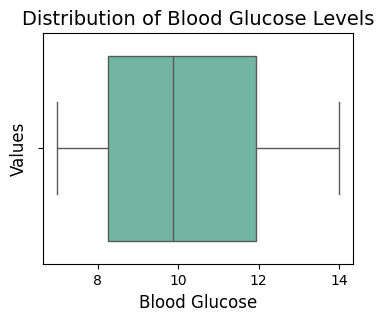

In [9]:
# Identify outliers by visualising the distribution of BloodGlucose with a boxplot. Use color-blind friendly colors

# Create the boxplot
plt.figure(figsize=(4, 3))
sns.boxplot(x='BloodGlucose', data=df, color='#66c2a5') #Color-blind friendly color

# Customize the plot
plt.title('Distribution of Blood Glucose Levels', fontsize=14)
plt.xlabel('Blood Glucose', fontsize=12)
plt.ylabel('Values', fontsize=12)

plt.show()

In [10]:
# Use the IQR method to remove outliers

# Calculate Q1, Q3, and IQR
Q1 = df['BloodGlucose'].quantile(0.25)
Q3 = df['BloodGlucose'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['BloodGlucose'] < lower_bound) | (df['BloodGlucose'] > upper_bound)]

# Remove outliers
df_no_outliers = df[(df['BloodGlucose'] >= lower_bound) & (df['BloodGlucose'] <= upper_bound)]

# Display the number of outliers removed
print(f"Number of outliers removed: {len(outliers)}")

Number of outliers removed: 0


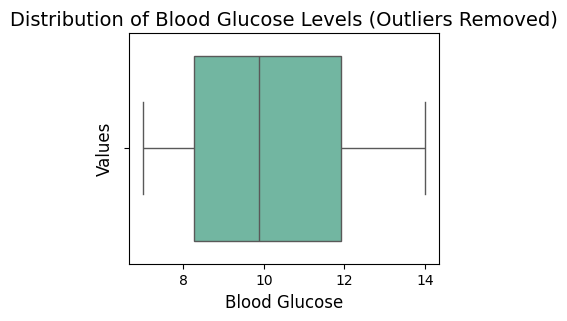

In [11]:
# Re-examine the boxplot without outliers
plt.figure(figsize=(4, 3))
sns.boxplot(x='BloodGlucose', data=df_no_outliers, color='#66c2a5') #Color-blind friendly color

# Customize the plot
plt.title('Distribution of Blood Glucose Levels (Outliers Removed)', fontsize=14)
plt.xlabel('Blood Glucose', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.show()

## Test for normality and homogeneity of variance

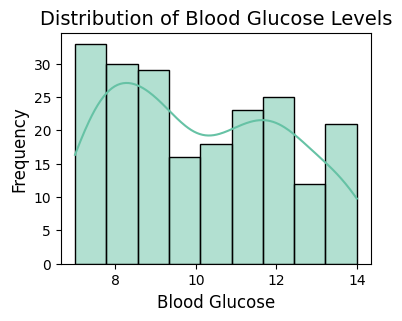

In [12]:
# Visualise the distribution of BloodGlucose with a histogram
plt.figure(figsize=(4, 3))
sns.histplot(df['BloodGlucose'], kde=True, color='#66c2a5')  #Color-blind friendly color
plt.title('Distribution of Blood Glucose Levels', fontsize=14)
plt.xlabel('Blood Glucose', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

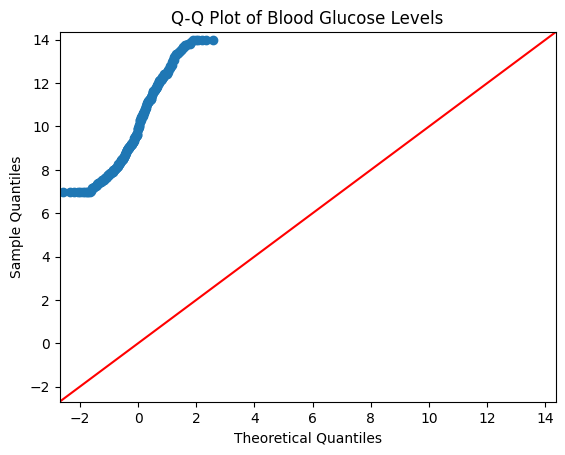

In [13]:
# Visualise the distribution of residuals with a Q-Q plot
from statsmodels.graphics.gofplots import qqplot # Import qqplot from the correct submodule
qqplot(df['BloodGlucose'], line='45')
plt.title('Q-Q Plot of Blood Glucose Levels')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

In [14]:
# test BloodGlucose for normality using shapiro wilks test

# Test for normality using Shapiro-Wilk test
from scipy.stats import shapiro

# Assuming 'df' is your DataFrame and 'BloodGlucose' is the column
stat, p = shapiro(df['BloodGlucose'].dropna()) # Drop NA values for the test

print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.944, p=0.000
Sample does not look Gaussian (reject H0)


In [15]:
# test BloodGlucose for homogeneity of variance using Bartlett's test if Shapiro-Wilk Test Statistic p-value>0.05 or use Levene's Test if Shapiro-Wilk Test Statistic p-value<0.05

# Test for homogeneity of variance

# Bartlett's test if Shapiro-Wilk p-value > 0.05
if p > alpha:
    stat, p_bartlett = scipy.stats.bartlett(df[df['Group'] == 'Control']['BloodGlucose'],
                                            df[df['Group'] == 'Treatment']['BloodGlucose'])
    print('Bartlett Test Statistics=%.3f, p=%.3f' % (stat, p_bartlett))
    if p_bartlett > alpha:
        print('Samples have equal variance (fail to reject H0)')
    else:
        print('Samples do not have equal variance (reject H0)')

# Levene's test if Shapiro-Wilk p-value < 0.05
else:
    # Remove NaN (missing) values before applying the Levene test
    control_data = df[df['Group'] == 'Control']['BloodGlucose'].dropna()
    treatment_data = df[df['Group'] == 'Treatment']['BloodGlucose'].dropna()

    stat, p_levene = scipy.stats.levene(control_data, treatment_data)
    print('Levene Test Statistics=%.3f, p=%.3f' % (stat, p_levene))

    if p_levene > alpha:
        print('Samples have equal variance (fail to reject H0)')
    else:
        print('Samples do not have equal variance (reject H0)')

Levene Test Statistics=0.681, p=0.410
Samples have equal variance (fail to reject H0)


Data are not normally distributed so need to be transformed or scaled.

## Log-transform data

In [16]:
# Create a new column with log-transformed blood glucose values
df_no_outliers['log_BloodGlucose'] = np.log(df_no_outliers['BloodGlucose'])

# Display the first few rows to verify the new column
print(df_no_outliers.head())

   ID    Group      Time  BloodGlucose  log_BloodGlucose
0   1  Control  Baseline      9.621781          2.264029
1   1  Control    Week12     10.304861          2.332616
2   2  Control  Baseline     13.655000          2.614106
3   2  Control    Week12     14.000000          2.639057
4   3  Control  Baseline     12.123958          2.495183


In [17]:
# Ensure Group and Time are categorical
df_no_outliers['Group'] = df_no_outliers['Group'].astype('category')
df_no_outliers['Time'] = df_no_outliers['Time'].astype('category')

# Check data types of columns in the DataFrame
df_no_outliers.dtypes

,0
ID,int64
Group,category
Time,category
BloodGlucose,float64
log_BloodGlucose,float64


# Statistical analysis

## Two-way repeated-measures ANOVA

In [18]:
# Perform a two-way (Group_Encoded  x Time_Encoded) mixed ANOVA on BloodGlucose  with posthoc using dependent T-tests between groups and a Bonferroni correction for multiple comparisons

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Fit the ANOVA model
model = ols('log_BloodGlucose ~ C(Group) * C(Time)', data=df_no_outliers).fit()

# Perform the ANOVA
anova_results = anova_lm(model)

# Display the results
print(anova_results)

# Interpret the p-values
alpha = 0.05  # Significance level
for term, p_value in anova_results['PR(>F)'].items():
    if p_value < alpha:
        print(f"\nFactor/Interaction '{term}' is statistically significant (p-value = {p_value:.4f}).")
    else:
        print(f"\nFactor/Interaction '{term}' is not statistically significant (p-value = {p_value:.4f}).")

# Post hoc analysis - Pairwise comparisons using Tukey's HSD
# If 'Group' is significant, perform Tukey's test for pairwise comparisons of Group
if anova_results.loc['C(Group)', 'PR(>F)'] < alpha:
    print("\nPost Hoc Test - Pairwise Comparison for 'Group' (Control vs Treatment):")
    tukey_group = pairwise_tukeyhsd(df_no_outliers['log_BloodGlucose'], df_no_outliers['Group'])
    print(tukey_group)

# If 'Time' is significant, perform Tukey's test for pairwise comparisons of Time
if anova_results.loc['C(Time)', 'PR(>F)'] < alpha:
    print("\nPost Hoc Test - Pairwise Comparison for 'Time' (Baseline vs Week12):")
    tukey_time = pairwise_tukeyhsd(df_no_outliers['log_BloodGlucose'], df_no_outliers['Time'])
    print(tukey_time)

# If interaction ('Group:Time') is significant, perform Tukey's test for pairwise comparisons of each combination
if anova_results.loc['C(Group):C(Time)', 'PR(>F)'] < alpha:
    print("\nPost Hoc Test - Pairwise Comparison for 'Group x Time' interaction:")
    # Create a new grouping variable by combining 'Group' and 'Time'
    df_no_outliers['Group_Time'] = df_no_outliers['Group'].astype(str) + '_' + df_no_outliers['Time'].astype(str) # Create a new column 'Group_Time'
    tukey_interaction = pairwise_tukeyhsd(df_no_outliers['log_BloodGlucose'], df_no_outliers['Group_Time'])  # Use the new column for Tukey's test
    print(tukey_interaction)

                     df    sum_sq   mean_sq          F    PR(>F)
C(Group)            1.0  0.499983  0.499983  12.224610  0.000579
C(Time)             1.0  0.028524  0.028524   0.697410  0.404637
C(Group):C(Time)    1.0  0.221417  0.221417   5.413672  0.020966
Residual          203.0  8.302635  0.040900        NaN       NaN

Factor/Interaction 'C(Group)' is statistically significant (p-value = 0.0006).

Factor/Interaction 'C(Time)' is not statistically significant (p-value = 0.4046).

Factor/Interaction 'C(Group):C(Time)' is statistically significant (p-value = 0.0210).

Factor/Interaction 'Residual' is not statistically significant (p-value = nan).

Post Hoc Test - Pairwise Comparison for 'Group' (Control vs Treatment):
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
Control Treatment  -0.0983 0.0007 -0.1543 -0.0423   True
------------------------------------------

### Effect sizes and Statistical power

In [21]:
# Calculate effect size (eta-squared) of the ANOVA model using pingouin
!pip install pingouin --quiet --progress-bar off
import pingouin as pg

aov = pg.mixed_anova(dv='log_BloodGlucose', between='Group', within='Time', subject='ID', data=df_no_outliers)
print(aov)

        Source        SS  DF1  DF2        MS           F         p-unc  \
0        Group  0.474457    1   93  0.474457    5.852399  1.750164e-02   
1         Time  0.023987    1   93  0.023987   66.270892  1.721286e-12   
2  Interaction  0.229395    1   93  0.229395  633.763589  2.662385e-43   

        np2  eps  
0  0.059203  NaN  
1  0.416089  1.0  
2  0.872035  NaN  


In [22]:
# Interpret eta-squared
def get_effect_size_description(eta, criteria):
    if eta < criteria['small']:
        return "trivial"
    elif eta < criteria['medium']:
        return "small"
    elif eta < criteria['large']:
        return "medium"
    else:
        return "large"

# Define the criteria thresholds for small and medium effect sizes.
eta_squared_criteria = {
        'small': 0.01,
    'medium': 0.06,
    'large': 0.14
}

# Extract relevant statistics
eta_squared_group = aov['np2'][0]  # Partial eta-squared for the 'Group' effect
eta_squared_time = aov['np2'][1]  # Partial eta-squared for the 'Time' effect
eta_squared_interaction = aov['np2'][2]  # Partial eta-squared for the 'Interaction' effect

# define the descriptors
effect_size_description_group = get_effect_size_description(eta_squared_group, eta_squared_criteria)
effect_size_description_time = get_effect_size_description(eta_squared_time, eta_squared_criteria)
effect_size_description_interaction = get_effect_size_description(eta_squared_interaction, eta_squared_criteria)

print(f"Partial Eta Squared for Group = {eta_squared_group:.3f}, indicating a {effect_size_description_group} effect.")
print(f"Partial Eta Squared for Time = {eta_squared_time:.3f}, indicating a {effect_size_description_time} effect.")
print(f"Partial Eta Squared for GroupxTime = {eta_squared_interaction:.3f}, indicating a {effect_size_description_interaction} effect.")

Partial Eta Squared for Group = 0.059, indicating a small effect.
Partial Eta Squared for Time = 0.416, indicating a large effect.
Partial Eta Squared for GroupxTime = 0.872, indicating a large effect.


In [23]:
# convert eta-squared to cohen's d
def eta_squared_to_cohens_d(eta_squared, n):
    cohens_d = np.sqrt(eta_squared / (1 - eta_squared)) * np.sqrt(2)
    return cohens_d

# interpret cohen's d effect sizes
def interpret_cohens_d(cohens_d):
    if abs(cohens_d) < 0.2:
        return "Trivial effect"
    elif abs(cohens_d) < 0.5:
        return "Small effect"
    elif abs(cohens_d) < 0.8:
        return "Medium effect"
    else:
        return "Large effect"

# Calculate Cohen's d:
n_group = len(df_no_outliers)  # sample size
cohens_d_group = eta_squared_to_cohens_d(eta_squared_group, n_group)
cohens_d_time = eta_squared_to_cohens_d(eta_squared_time, n_group)
cohens_d_interaction = eta_squared_to_cohens_d(eta_squared_interaction, n_group)

# define cohen's d interpretation
cohens_interpretation_group = interpret_cohens_d(cohens_d_group)
cohens_interpretation_time = interpret_cohens_d(cohens_d_time)
cohens_interpretation_interaction = interpret_cohens_d(cohens_d_interaction)


print(f"Cohen's d for Group effect: {cohens_d_group:.3f}, which is a {cohens_interpretation_group}")

print(f"Cohen's d for Time effect: {cohens_d_time:.3f}, which is a {cohens_interpretation_time}")

print(f"Cohen's d for Interaction effect: {cohens_d_interaction:.3f}, which is a {cohens_interpretation_interaction}")

Cohen's d for Group effect: 0.355, which is a Small effect
Cohen's d for Time effect: 1.194, which is a Large effect
Cohen's d for Interaction effect: 3.692, which is a Large effect


In [24]:
# Calculate statistical power for main effects and interaction
import statsmodels.stats.power as smp

# Define parameters for power analysis
alpha = 0.05       # Significance level
n_per_group = 56   # Sample size per group (from previous power calculation)

# Power analysis for main effects (Time)
power_time = smp.FTestAnovaPower().solve_power(effect_size=cohens_d_time,
                                             alpha=alpha,
                                             nobs=n_per_group,
                                             k_groups=2)  # Two time points (Baseline and Week12)
print(f"Statistical power for main effect of Time: {power_time:.4f}")

# Power analysis for main effects (Group)
power_group = smp.FTestAnovaPower().solve_power(effect_size=cohens_d_group,
                                              alpha=alpha,
                                              nobs=n_per_group,
                                              k_groups=2)  # Two groups (Control and Treatment)
print(f"Statistical power for main effect of Group: {power_group:.4f}")

Statistical power for main effect of Time: 1.0000
Statistical power for main effect of Group: 0.7413


## Linear mixed model

In [25]:
# use a linear mixed model to analyse the change in BloodGlucose

import statsmodels.formula.api as smf

# Fit the linear mixed model
lmm_model = smf.mixedlm("log_BloodGlucose ~ C(Group) * C(Time)", df_no_outliers, groups=df_no_outliers["ID"]).fit()

# Print the model summary
print(lmm_model.summary())

                       Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        log_BloodGlucose
No. Observations:        207            Method:                    REML            
No. Groups:              112            Scale:                     0.0004          
Min. group size:         1              Log-Likelihood:            216.1173        
Max. group size:         2              Converged:                 Yes             
Mean group size:         1.8                                                       
-----------------------------------------------------------------------------------
                                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                                2.323    0.027  85.812 0.000  2.270  2.376
C(Group)[T.Treatment]                   -0.038    0.038  -0.997 0.319 -0.113  0.037
C(Time)[T.Week1

In [26]:
# Post-hoc tests with Bonferroni correction
# Extract p-values for the relevant coefficients
p_values = lmm_model.pvalues[1:]  # Exclude the intercept
print(p_values)

# Number of comparisons
num_comparisons = len(p_values)

# Bonferroni correction
bonferroni_alpha = 0.05 / num_comparisons

# Print adjusted p-values and significance
print("\nPost-hoc tests with Bonferroni correction:")
for i, (coef, p) in enumerate(p_values.items()):
    adjusted_p = p * num_comparisons  # Adjust the p-values
    print(f"{coef}: p-value = {p:.4f}, Adjusted p-value = {adjusted_p:.4f}", end=" ")
    if adjusted_p < 0.05:
        print("(Significant after Bonferroni correction)")
    else:
        print("(Not significant after Bonferroni correction)")

C(Group)[T.Treatment]                       3.187458e-01
C(Time)[T.Week12]                           1.005713e-32
C(Group)[T.Treatment]:C(Time)[T.Week12]    8.577618e-140
Group Var                                   5.918838e-07
dtype: float64

Post-hoc tests with Bonferroni correction:
C(Group)[T.Treatment]: p-value = 0.3187, Adjusted p-value = 1.2750 (Not significant after Bonferroni correction)
C(Time)[T.Week12]: p-value = 0.0000, Adjusted p-value = 0.0000 (Significant after Bonferroni correction)
C(Group)[T.Treatment]:C(Time)[T.Week12]: p-value = 0.0000, Adjusted p-value = 0.0000 (Significant after Bonferroni correction)
Group Var: p-value = 0.0000, Adjusted p-value = 0.0000 (Significant after Bonferroni correction)


### Effect sizes and Statistical power

In [27]:
# Calculate Cohen's d for the LMM model
# NOTE: Cohen's d is not directly provided by mixedlm summary.  We need to calculate it from the coefficients and standard errors.

# Extract the relevant coefficients and standard errors
group_effect_coefficient = lmm_model.params['C(Group)[T.Treatment]']
group_effect_stderr = lmm_model.bse['C(Group)[T.Treatment]']

time_effect_coefficient = lmm_model.params['C(Time)[T.Week12]']
time_effect_stderr = lmm_model.bse['C(Time)[T.Week12]']

interaction_effect_coefficient = lmm_model.params['C(Group)[T.Treatment]:C(Time)[T.Week12]']
interaction_effect_stderr = lmm_model.bse['C(Group)[T.Treatment]:C(Time)[T.Week12]']

# Calculate Cohen's d (this is a simplified version; more robust methods may exist)
cohens_d_group_lmm = group_effect_coefficient / group_effect_stderr
cohens_d_time_lmm = time_effect_coefficient / time_effect_stderr
cohens_d_interaction_lmm = interaction_effect_coefficient / interaction_effect_stderr

# Interpret the effect sizes
print(f"Cohen's d for Group effect (LMM): {cohens_d_group_lmm:.3f}, {interpret_cohens_d(cohens_d_group_lmm)}")
print(f"Cohen's d for Time effect (LMM): {cohens_d_time_lmm:.3f}, {interpret_cohens_d(cohens_d_time_lmm)}")
print(f"Cohen's d for Interaction effect (LMM): {cohens_d_interaction_lmm:.3f}, {interpret_cohens_d(cohens_d_interaction_lmm)}")

Cohen's d for Group effect (LMM): -0.997, Large effect
Cohen's d for Time effect (LMM): 11.914, Large effect
Cohen's d for Interaction effect (LMM): -25.170, Large effect


In [28]:
# Calculate statistical power for main effects and interaction using Cohen's d from the LMM

# Define parameters for power analysis
alpha = 0.05       # Significance level
n_per_group = 56   # Sample size per group (adjust if necessary based on your data)

# Power analysis for main effects (Time) using Cohen's d from LMM
power_time_lmm = smp.FTestAnovaPower().solve_power(effect_size=cohens_d_time_lmm,
                                                alpha=alpha,
                                                nobs=n_per_group,
                                                k_groups=2)  # Two time points
print(f"Statistical power for main effect of Time (LMM): {power_time_lmm:.4f}")

# Power analysis for main effects (Group) using Cohen's d from LMM
power_group_lmm = smp.FTestAnovaPower().solve_power(effect_size=cohens_d_group_lmm,
                                                 alpha=alpha,
                                                 nobs=n_per_group,
                                                 k_groups=2)  # Two groups
print(f"Statistical power for main effect of Group (LMM): {power_group_lmm:.4f}")

# Power analysis for interaction using Cohen's d from LMM
power_interaction_lmm = smp.FTestAnovaPower().solve_power(effect_size=cohens_d_interaction_lmm,
                                                      alpha=alpha,
                                                      nobs=n_per_group,
                                                      k_groups=2)  # Adjust k_groups as needed for interaction
print(f"Statistical power for interaction effect (LMM): {power_interaction_lmm:.4f}")

Statistical power for main effect of Time (LMM): 1.0000
Statistical power for main effect of Group (LMM): 1.0000
Statistical power for interaction effect (LMM): 1.0000


## Bayesian model

In [29]:
# install packages
!pip install pymc --quiet --progress-bar off
!pip install arviz --quiet --progress-bar off
# load libraries
import pymc as pm
import arviz as az

Output()


 BFMI: 1.03, i.e., Anecdotal evidence in favor of the alternative hypothesis (a treatment effect).

 Bayesian posterior distribution plot:

95% HDI for delta_mu: (-0.155, -0.041)
The 95% HDI excludes zero.


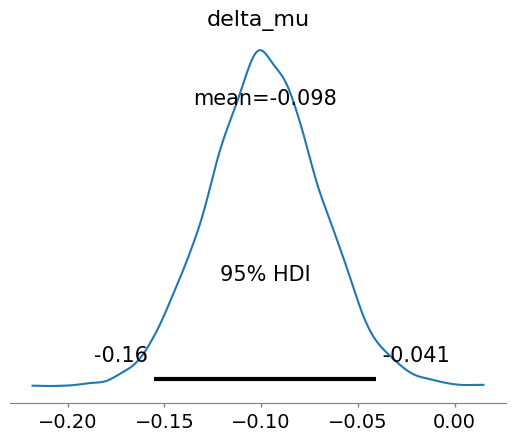

In [30]:
# Use a Bayesian model to compare log_BloodGlucose between groups (Treatment vs Control) in df_no_outliers.

# Prepare the data for the Bayesian model
treatment_glucose = df_no_outliers.loc[df_no_outliers['Group'] == 'Treatment', 'log_BloodGlucose']
control_glucose = df_no_outliers.loc[df_no_outliers['Group'] == 'Control', 'log_BloodGlucose']


with pm.Model() as model:
    # Priors for group means
    mu_treatment = pm.Normal("mu_treatment", mu=0, sigma=10)  # Adjust prior as needed
    mu_control = pm.Normal("mu_control", mu=0, sigma=10)      # Adjust prior as needed

    # Priors for group standard deviations
    sigma_treatment = pm.HalfNormal("sigma_treatment", sigma=5)  # Adjust prior as needed
    sigma_control = pm.HalfNormal("sigma_control", sigma=5)      # Adjust prior as needed

    # Likelihoods for the observed data
    treatment_obs = pm.Normal("treatment_obs", mu=mu_treatment, sigma=sigma_treatment, observed=treatment_glucose)
    control_obs = pm.Normal("control_obs", mu=mu_control, sigma=sigma_control, observed=control_glucose)

    # Calculate the difference in means
    delta_mu = pm.Deterministic("delta_mu", mu_treatment - mu_control)

    # Sample from the posterior distribution
    idata = pm.sample(draws=4000, tune=2000, return_inferencedata=True, target_accept=0.95)

# Calculate Bayes factor
bfmi = az.bfmi(idata)

# Extract the desired value (e.g., the mean) from the array
bfmi_value = np.mean(bfmi) # Assuming you want to print the average BFMI

# Interpret Bayes factor
# Interpretation Guidelines (Jeffreys' scale):
def interpret_bfmi(bfmi_value):
    """Interprets the Bayes Factor Model Information (BFMI) value based on predefined criteria."""

    if bfmi_value > 30:
        interpretation = "Very strong evidence in favor of the alternative hypothesis (a treatment effect)."
    elif bfmi_value > 10:
        interpretation = "Strong evidence in favor of the alternative hypothesis (a treatment effect)."
    elif bfmi_value > 3:
        interpretation = "Moderate evidence in favor of the alternative hypothesis (a treatment effect)."
    elif bfmi_value > 1:
        interpretation = "Anecdotal evidence in favor of the alternative hypothesis (a treatment effect)."
    elif bfmi_value < 1/30:
        interpretation = "Very strong evidence in favor of the null hypothesis (no treatment effect)."
    elif bfmi_value < 1/10:
        interpretation = "Strong evidence in favor of the null hypothesis (no treatment effect)."
    elif bfmi_value < 1/3:
        interpretation = "Moderate evidence in favor of the null hypothesis (no treatment effect)."
    else:
        interpretation = "Evidence for the alternative and null hypotheses is unclear."  # Added for bfmi == 1

    return interpretation

BFMI_interpretation = interpret_bfmi(bfmi_value)

# Print the Bayes factor
print(f"\n BFMI: {bfmi_value:.2f}, i.e., {BFMI_interpretation}")

# Plot the Bayesian posterior distribution
print(f"\n Bayesian posterior distribution plot:")
az.plot_posterior(idata, var_names=["delta_mu"], hdi_prob=0.95);

# Determine whether the 95% HDI in the Bayesian posterior distribution plot excludes zero
# NOTE: assume 'idata' is your InferenceData object from the Bayesian model
hdi_intervals = az.hdi(idata, var_names=["delta_mu"], hdi_prob=0.95)
lower_bound = hdi_intervals["delta_mu"][0]
upper_bound = hdi_intervals["delta_mu"][1]

print(f"\n95% HDI for delta_mu: ({lower_bound:.3f}, {upper_bound:.3f})")

if lower_bound > 0 or upper_bound < 0:
  print("The 95% HDI excludes zero.")
else:
  print("The 95% HDI includes zero.")

### Statistical power

In [31]:
# Calculate the statistical power of the Bayes model
# NOTE: Assume 'idata' is your InferenceData object from the Bayesian model and 'delta_mu' is the variable representing the difference in means

# Calculate the posterior probability of the difference in means being greater than zero
posterior_samples = idata.posterior["delta_mu"].values.flatten()
power = np.mean(posterior_samples > 0)  # Proportion of samples above zero
print(f"Statistical power of the Bayesian model: {power:.4f}")

Statistical power of the Bayesian model: 0.0006


## Standardized mean difference (effect size)

In [32]:
# Calculate Pooled_Baseline_SD: standard deviation of 'BloodGlucose' at 'Baseline'
baseline_values = df_no_outliers[df_no_outliers['Time'] == 'Baseline']['BloodGlucose']
Pooled_Baseline_SD = baseline_values.std()
print("Pooled Baseline SD:", Pooled_Baseline_SD)

Pooled Baseline SD: 2.065357578634652


In [33]:
# Create a new dataframe with columns: ID, Group, and delta_BloodGlucose.
# First, pivot the data so that each row represents one subject with columns for Baseline and Week12.
df_pivot = df_no_outliers.pivot(index='ID', columns='Time', values='BloodGlucose').reset_index()

# Merge the group information (assuming it's the same for both rows per ID)
df_pivot = df_pivot.merge(df_no_outliers[['ID', 'Group']].drop_duplicates(), on='ID')

# Calculate delta_BloodGlucose: Week12 minus Baseline
df_pivot['delta_BloodGlucose'] = df_pivot['Week12'] - df_pivot['Baseline']

# Create the new dataframe with only the desired columns
delta_df = df_pivot[['ID', 'Group', 'delta_BloodGlucose']]
print(delta_df.head())

   ID    Group  delta_BloodGlucose
0   1  Control            0.683080
1   2  Control            0.345000
2   3  Control            0.394048
3   4  Control            0.602653
4   5  Control            0.519416


In [34]:
# Calculate the standardized mean difference for each group
# For each group, compute the mean difference (Week12 - Baseline) and divide by the pooled baseline SD.
control_values = delta_df[delta_df['Group'] == 'Control']['delta_BloodGlucose']
treatment_values = delta_df[delta_df['Group'] == 'Treatment']['delta_BloodGlucose']

control_mean_diff = control_values.mean()
treatment_mean_diff = treatment_values.mean()

# Calculate the 95% CI for the mean difference in the Control group
n_control = control_values.count()
control_std = control_values.std(ddof=1)
control_se = control_std / np.sqrt(n_control)
# t critical value for a 95% CI with (n-1) degrees of freedom
import scipy.stats as stats
t_crit_control = stats.t.ppf(1-0.025, df=n_control-1)

control_ci_lower = control_mean_diff - t_crit_control * control_se
control_ci_upper = control_mean_diff + t_crit_control * control_se

# Calculate the 95% CI for the mean difference in the Treatment group
n_treatment = treatment_values.count()
treatment_std = treatment_values.std(ddof=1)
treatment_se = treatment_std / np.sqrt(n_treatment)
t_crit_treatment = stats.t.ppf(1-0.025, df=n_treatment-1)

treatment_ci_lower = treatment_mean_diff - t_crit_treatment * treatment_se
treatment_ci_upper = treatment_mean_diff + t_crit_treatment * treatment_se

print(f"Mean difference for Control [95% CI]: {control_mean_diff:.3f} [{control_ci_lower:.3f}, {control_ci_upper:.3f}]")
print(f"Mean difference for Treatment [95% CI]: {treatment_mean_diff:.3f} [{treatment_ci_lower:.3f}, {treatment_ci_upper:.3f}]")

control_SMD = control_mean_diff / Pooled_Baseline_SD
treatment_SMD = treatment_mean_diff / Pooled_Baseline_SD

# Interpret SMD effect sizes using Cohen's d criteria
def interpret_SMD(SMD):
    if abs(SMD) < 0.2:
        return "Trivial"
    elif abs(SMD) < 0.5:
        return "Small"
    elif abs(SMD) < 0.8:
        return "Medium"
    else:
        return "Large"

SMD_interpretation_Control = interpret_SMD(control_SMD)
SMD_interpretation_Treatment = interpret_SMD(treatment_SMD)

# Interpret the direction of change for Control
def interpret_direction_control(mean_diff):
    if mean_diff < 0:
        return "decrease in blood glucose"
    elif mean_diff > 0:
        return "increase in blood glucose"
    else:
        return "no change in blood glucose"

# Interpret the direction of change for Treatment
def interpret_direction_treatment(mean_diff):
    if mean_diff < 0:
        return "decrease in blood glucose"
    elif mean_diff > 0:
        return "increase in blood glucose"
    else:
        return "no change in blood glucose"

direction_interpretation_Control = interpret_direction_control(control_mean_diff)
direction_interpretation_Treatment = interpret_direction_treatment(treatment_mean_diff)

# Calculate the 95% CI for the SMD
# since SMD = mean_diff / Pooled_Baseline_SD, the SE for SMD is:
control_SMD_se = control_se / Pooled_Baseline_SD
treatment_SMD_se = treatment_se / Pooled_Baseline_SD

control_SMD_ci_lower = control_SMD - t_crit_control * control_SMD_se
control_SMD_ci_upper = control_SMD + t_crit_control * control_SMD_se

treatment_SMD_ci_lower = treatment_SMD - t_crit_treatment * treatment_SMD_se
treatment_SMD_ci_upper = treatment_SMD + t_crit_treatment * treatment_SMD_se

print(f"\nSMD (effect size) for Control [95% CI]: {control_SMD:.3f} [{control_SMD_ci_lower:.3f}, {control_SMD_ci_upper:.3f}], which is a {SMD_interpretation_Control} {direction_interpretation_Control}")
print(f"SMD (effect size) for Treatment [95% CI]: {treatment_SMD:.3f} [{treatment_SMD_ci_lower:.3f}, {treatment_SMD_ci_upper:.3f}], which is a {SMD_interpretation_Treatment} {direction_interpretation_Treatment}")

Mean difference for Control [95% CI]: 0.464 [0.409, 0.520]
Mean difference for Treatment [95% CI]: -0.876 [-0.957, -0.796]

SMD (effect size) for Control [95% CI]: 0.225 [0.198, 0.252], which is a Small increase in blood glucose
SMD (effect size) for Treatment [95% CI]: -0.424 [-0.463, -0.386], which is a Small decrease in blood glucose


# Data visualisation
<p>Several methods for presenting the results of an RCT.
<p>The prefered option is the <em>Estimation plot</em>, the final option.

## Boxplot

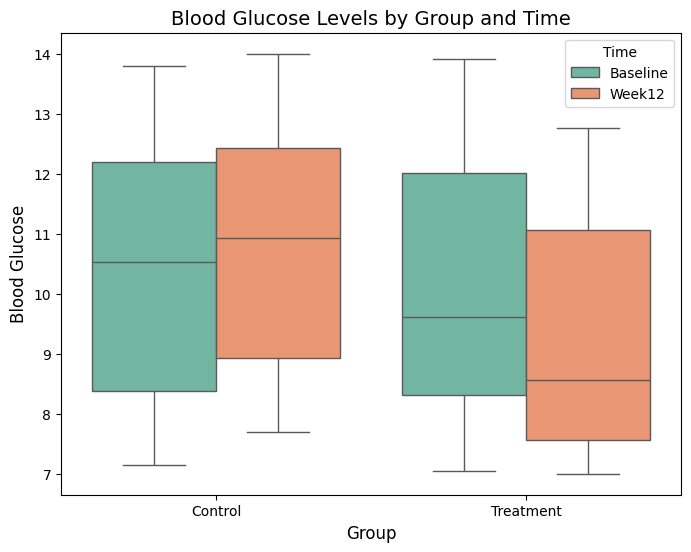

In [35]:
# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Group', y='BloodGlucose', hue='Time', data=df_no_outliers, palette="Set2") #Color-blind friendly color
plt.title('Blood Glucose Levels by Group and Time', fontsize=14)
plt.xlabel('Group', fontsize=12)
plt.ylabel('Blood Glucose', fontsize=12)
plt.show()

## Violin Plot

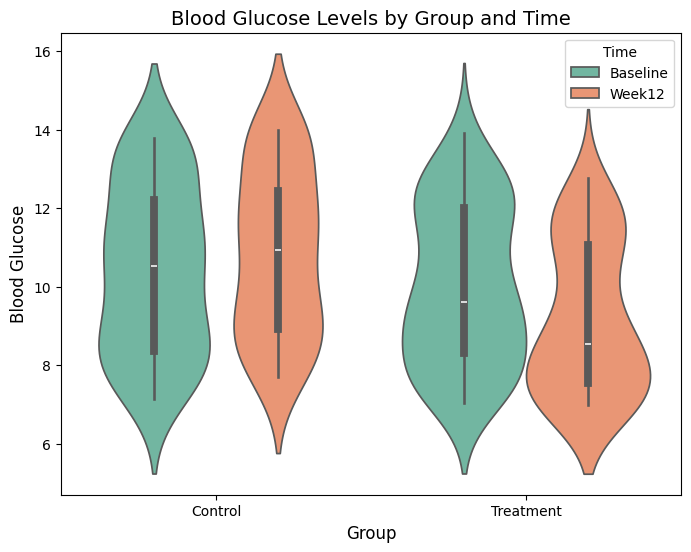

In [36]:
# Create the violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(x='Group', y='BloodGlucose', hue='Time', data=df_no_outliers, palette="Set2")
plt.title('Blood Glucose Levels by Group and Time', fontsize=14)
plt.xlabel('Group', fontsize=12)
plt.ylabel('Blood Glucose', fontsize=12)
plt.show()

## Beeswarm plot

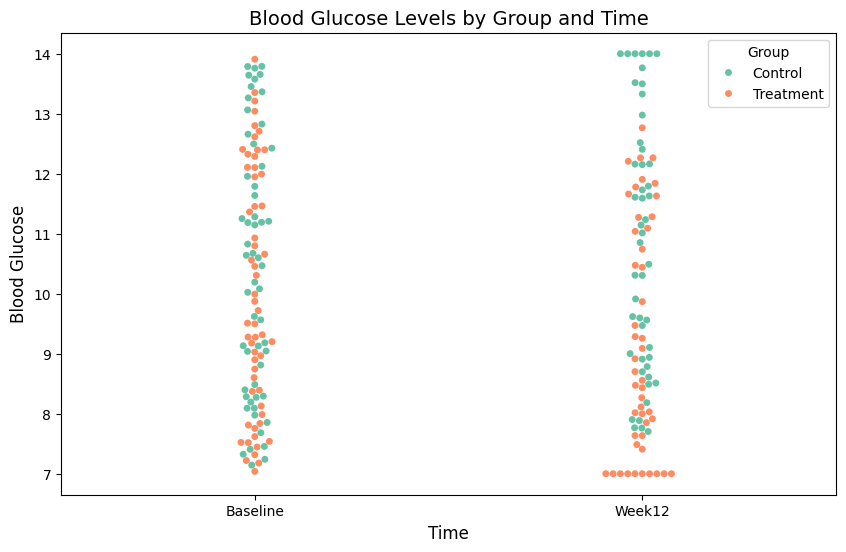

In [37]:
# Create the beeswarm plot
plt.figure(figsize=(10, 6))
sns.swarmplot(x='Time', y='BloodGlucose', hue='Group', data=df_no_outliers, palette="Set2")
plt.title('Blood Glucose Levels by Group and Time', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Blood Glucose', fontsize=12)
plt.show()

## Raincloud plot

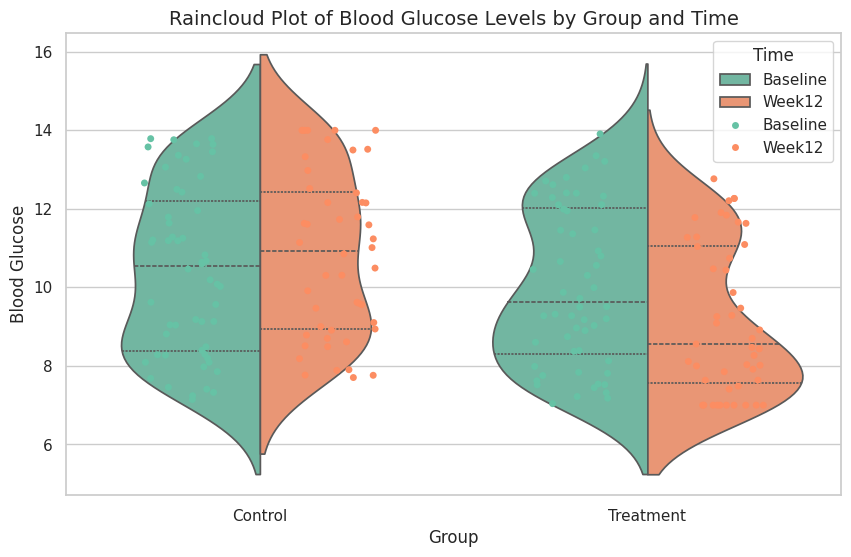

In [38]:
# build a raincloud plot of BloodGlucose by group and time in df_no_outliers
def raincloud_plot(df, x_col, y_col, hue_col):
    plt.figure(figsize=(10, 6))
    sns.set_theme(style="whitegrid")
    sns.violinplot(x=x_col, y=y_col, hue=hue_col, data=df, split=True, inner="quartile", palette="Set2")
    sns.stripplot(x=x_col, y=y_col, hue=hue_col, data=df, dodge=True, jitter=0.2, palette="Set2")
    plt.title('Raincloud Plot of Blood Glucose Levels by Group and Time', fontsize=14)
    plt.xlabel('Group', fontsize=12)
    plt.ylabel('Blood Glucose', fontsize=12)
    plt.show()

raincloud_plot(df_no_outliers, 'Group', 'BloodGlucose', 'Time')

## Estimation plot (Gardner-Altman plot)
https://acclab.github.io/DABEST-python/

In [39]:
# Import necessary libraries
!pip install dabest --quiet --progress-bar off
import dabest

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.1.3 which is incompatible.
distributed-ucxx-cu12 0.42.0 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.2 which is incompatible.
cuml-cu12 25.2.1 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.2 which is incompatible.
dask-cuda 25.2.0 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.2 which is incompatible.
cudf-cu12 25.2.1 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.2 which is incompatible.
Pre-compiling numba functions for DABEST...


Compiling numba functions: 100%|██████████| 11/11 [00:11<00:00,  1.06s/it]

Numba compilation complete!


In [40]:
# view dataframe
print(df_no_outliers.head())

   ID    Group      Time  BloodGlucose  log_BloodGlucose        Group_Time
0   1  Control  Baseline      9.621781          2.264029  Control_Baseline
1   1  Control    Week12     10.304861          2.332616    Control_Week12
2   2  Control  Baseline     13.655000          2.614106  Control_Baseline
3   2  Control    Week12     14.000000          2.639057    Control_Week12
4   3  Control  Baseline     12.123958          2.495183  Control_Baseline


In [41]:
# load data into dabest
unpaired_deltadelta = dabest.load(data = df_no_outliers,
                                  x = ["Time", "Time"],
                                  y = "BloodGlucose",
                                  delta2 = True,
                                  experiment = "Group",
                                  ci=95,
                                  resamples=5000)
unpaired_deltadelta

DABEST v2025.03.27
                  
Good afternoon!
The current time is Fri Apr 11 15:59:23 2025.

Effect size(s) with 95% confidence intervals will be computed for:
1. Week12 Control minus Baseline Control
2. Week12 Treatment minus Baseline Treatment
3. Treatment minus Control (only for mean difference)

5000 resamples will be used to generate the effect size bootstraps.

In [42]:
# calculate the mean difference (use median＿diff for the median difference)
unpaired_deltadelta.mean_diff

DABEST v2025.03.27
                  
Good afternoon!
The current time is Fri Apr 11 15:59:30 2025.

The unpaired mean difference between Baseline Control and Week12 Control is 0.422 [95%CI -0.385, 1.21].
The p-value of the two-sided permutation t-test is 0.317, calculated for legacy purposes only. 

The unpaired mean difference between Baseline Treatment and Week12 Treatment is -0.852 [95%CI -1.6, -0.123].
The p-value of the two-sided permutation t-test is 0.0272, calculated for legacy purposes only. 

The delta-delta between Control and Treatment is -1.27 [95%CI -2.36, -0.158].
The p-value of the two-sided permutation t-test is 0.0282, calculated for legacy purposes only. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
Any p-value reported is the probability of observing the effect size (or greater),
assuming the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.


In [43]:
# calculate the mean difference with results of simulation
unpaired_deltadelta.mean_diff.results

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,...,pvalue_mann_whitney,statistic_mann_whitney,bec_difference,bec_bootstraps,bec_bca_interval_idx,bec_bca_low,bec_bca_high,bec_pct_interval_idx,bec_pct_low,bec_pct_high
0,Baseline Control,Week12 Control,56,48,mean difference,None,0.421526,95,-0.385013,1.209898,...,0.283395,1179.0,0.0,"[-0.5667942814447873, -0.18264404787456634, 0....","(119, 4869)",-0.788985,0.776943,"(125, 4875)",-0.780181,0.784457
1,Baseline Treatment,Week12 Treatment,56,47,mean difference,None,-0.852398,95,-1.596576,-0.123098,...,0.017248,1676.0,0.0,"[0.06303517363195432, -0.27609741576828384, -0...","(124, 4874)",-0.755111,0.757022,"(125, 4875)",-0.754676,0.758393


In [44]:
# show all statistical tests
unpaired_deltadelta.mean_diff.statistical_tests

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,Baseline Control,Week12 Control,56,48,mean difference,None,0.421526,95,-0.385013,1.209898,0.3168,0.312557,-1.015003,0.312910,-1.014153,0.283395,1179.0
1,Baseline Treatment,Week12 Treatment,56,47,mean difference,None,-0.852398,95,-1.596576,-0.123098,0.0272,0.029299,2.211383,0.030013,2.201001,0.017248,1676.0


### Mean difference plot
Edit plot aesthetics at https://acclab.github.io/DABEST-python/tutorials/09-plot_aesthetics.html

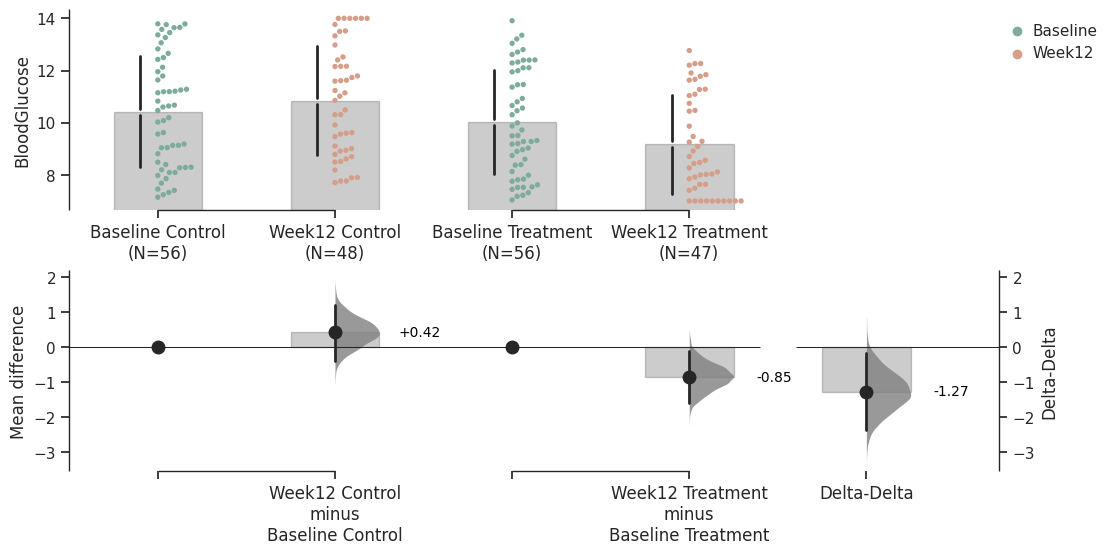

In [45]:
# build the delta-delta estimation plot with mean difference
unpaired_deltadelta.mean_diff.plot(
    custom_palette=sns.color_palette("Set2"), # color-blind friendly
    contrast_label="Mean difference",
    fig_size=(12, 6),
    raw_marker_size=2,
);

In [46]:
# standardize the delta-delta effect size with Hedge's g
unpaired_deltadelta.hedges_g

DABEST v2025.03.27
                  
Good afternoon!
The current time is Fri Apr 11 15:59:35 2025.

The unpaired Hedges' g between Baseline Control and Week12 Control is 0.198 [95%CI -0.187, 0.58].
The p-value of the two-sided permutation t-test is 0.317, calculated for legacy purposes only. 

The unpaired Hedges' g between Baseline Treatment and Week12 Treatment is -0.432 [95%CI -0.825, -0.0521].
The p-value of the two-sided permutation t-test is 0.0272, calculated for legacy purposes only. 

The delta g between Control and Treatment is -0.631 [95%CI -1.17, -0.0782].
The p-value of the two-sided permutation t-test is 0.0254, calculated for legacy purposes only. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
Any p-value reported is the probability of observing the effect size (or greater),
assuming the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the

In [47]:
# calculate the Hedges's g with results of simulation
unpaired_deltadelta.hedges_g.results

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,...,pvalue_mann_whitney,statistic_mann_whitney,bec_difference,bec_bootstraps,bec_bca_interval_idx,bec_bca_low,bec_bca_high,bec_pct_interval_idx,bec_pct_low,bec_pct_high
0,Baseline Control,Week12 Control,56,48,Hedges' g,None,0.198012,95,-0.187444,0.580463,...,0.283395,1179.0,0.0,"[-0.2562494838859451, -0.08398240204360188, 0....","(119, 4869)",-0.384233,0.370541,"(125, 4875)",-0.380640,0.373805
1,Baseline Treatment,Week12 Treatment,56,47,Hedges' g,None,-0.432165,95,-0.825402,-0.052087,...,0.017248,1676.0,0.0,"[0.03203393287097897, -0.13231067210308975, -0...","(124, 4874)",-0.378331,0.383954,"(125, 4875)",-0.377144,0.384246


In [48]:
# show all statistical tests
unpaired_deltadelta.hedges_g.statistical_tests

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,Baseline Control,Week12 Control,56,48,Hedges' g,None,0.198012,95,-0.187444,0.580463,0.3168,0.312557,-1.015003,0.312910,-1.014153,0.283395,1179.0
1,Baseline Treatment,Week12 Treatment,56,47,Hedges' g,None,-0.432165,95,-0.825402,-0.052087,0.0272,0.029299,2.211383,0.030013,2.201001,0.017248,1676.0


### Hedge's g plot
Edit plot aesthetics at https://acclab.github.io/DABEST-python/tutorials/09-plot_aesthetics.html

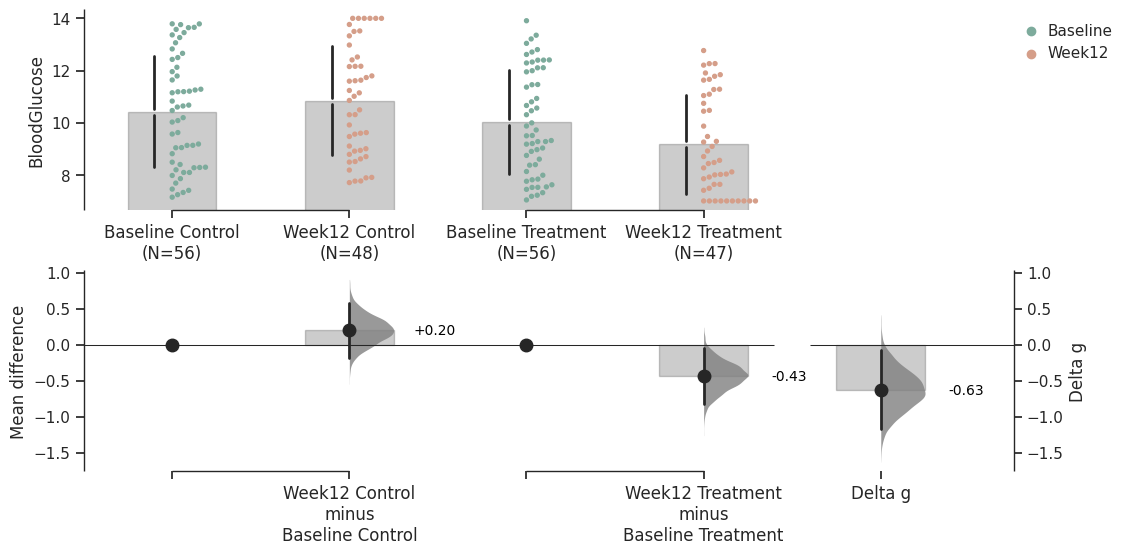

In [49]:
# Build the delta-delta estimation plot with Hedge's g
unpaired_deltadelta.hedges_g.plot(
    custom_palette=sns.color_palette("Set2"), # color-blind friendly
    contrast_label="Mean difference",
    fig_size=(12, 6),
    raw_marker_size=2,
);

In [50]:
# standardize the delta-delta effect size with Cohen's d
unpaired_deltadelta.cohens_d

DABEST v2025.03.27
                  
Good afternoon!
The current time is Fri Apr 11 15:59:40 2025.

The unpaired Cohen's d between Baseline Control and Week12 Control is 0.199 [95%CI -0.189, 0.585].
The p-value of the two-sided permutation t-test is 0.317, calculated for legacy purposes only. 

The unpaired Cohen's d between Baseline Treatment and Week12 Treatment is -0.435 [95%CI -0.832, -0.0525].
The p-value of the two-sided permutation t-test is 0.0272, calculated for legacy purposes only. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
Any p-value reported is the probability of observing theeffect size (or greater),
assuming the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.cohens_d.statistical_tests`

In [51]:
# standardize the delta-delta effect size with Cohen's d
unpaired_deltadelta.cohens_d.results

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,...,pvalue_mann_whitney,statistic_mann_whitney,bec_difference,bec_bootstraps,bec_bca_interval_idx,bec_bca_low,bec_bca_high,bec_pct_interval_idx,bec_pct_low,bec_pct_high
0,Baseline Control,Week12 Control,56,48,Cohen's d,None,0.199483,95,-0.188837,0.584775,...,0.283395,1179.0,0.0,"[-0.25801334385159513, -0.08456048397585572, 0...","(119, 4869)",-0.386878,0.373092,"(125, 4875)",-0.38326,0.376378
1,Baseline Treatment,Week12 Treatment,56,47,Cohen's d,None,-0.435407,95,-0.831596,-0.052477,...,0.017248,1676.0,0.0,"[0.03225443427795386, -0.13322141539127824, -0...","(124, 4874)",-0.380935,0.386597,"(125, 4875)",-0.37974,0.386891


In [52]:
# standardize the delta-delta effect size with Cohen's d
unpaired_deltadelta.cohens_d.statistical_tests

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,Baseline Control,Week12 Control,56,48,Cohen's d,None,0.199483,95,-0.188837,0.584775,0.3168,0.312557,-1.015003,0.312910,-1.014153,0.283395,1179.0
1,Baseline Treatment,Week12 Treatment,56,47,Cohen's d,None,-0.435407,95,-0.831596,-0.052477,0.0272,0.029299,2.211383,0.030013,2.201001,0.017248,1676.0


### Cohen's d plot
Edit plot aesthetics at https://acclab.github.io/DABEST-python/tutorials/09-plot_aesthetics.html

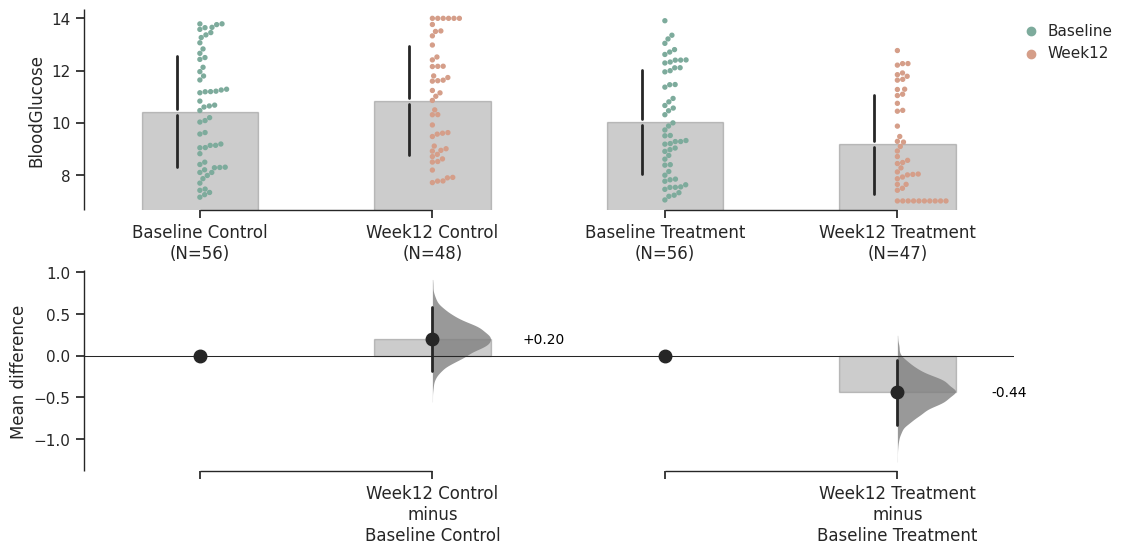

In [53]:
# Build the delta-delta estimation plot with Cohen's d
unpaired_deltadelta.cohens_d.plot(
    custom_palette=sns.color_palette("Set2"), # color-blind friendly
    contrast_label="Mean difference",
    fig_size=(12, 6),
    raw_marker_size=2,
);